# Previsão de Engajamento - Classificação

In [1]:
#@title Importações de pacote
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
BASE_PATH = 'dados/'

# 1 - Carregando os Dados

Carregando dados brutos.

In [3]:
dfx = pd.read_excel(BASE_PATH + 'full-preproc2-inputs.xlsx', index_col='ID')
dfx.head()


,Candidato_Bolsonaro,Candidato_Lula,Dispositivo Retórico,Main character,Retórica Aristotélica,Tipo de conteúdo,Texto / Hashtag,Tonalidade,Abordagem,Duracao,DiasDecorridos
ID,,,,,,,,,,,
7114971700365691904,1,0,Political Statement,Self alone,Pathos,Campaign Act,Hashtag,Neutral,Acclamation,57.93,94
7115050482179050496,1,0,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Positive,Acclamation,17.13,94
7115120078982630400,1,0,Commitment,Self + voters,Ethos,Political-Purposeful,Hashtag,Positive,Acclamation,52.54,94
7115161088219565056,1,0,Humor,Self alone,Nenhum,Personal,Hashtag,Positive,Acclamation,34.48,94
7115207919750253568,1,0,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Negative,Attack,66.66,94


In [4]:
dfy_full = pd.read_excel(BASE_PATH + 'full-preproc2-outputs.xlsx', index_col='ID')
dfy_full.head()

,Curtidas,Curtidas-Log,Curtidas-MinMax,Curtidas-Log-MinMax,Curtidas-2Classes-75p,Curtidas-2Classes-50p
ID,,,,,,
7114971700365691904,24400,4.387390,0.018396,0.374522,0,0
7115050482179050496,9163,3.962038,0.005674,0.217264,0,0
7115120078982630400,3485,3.542203,0.000933,0.062046,0,0
7115161088219565056,22100,4.344392,0.016476,0.358626,0,0
7115207919750253568,115700,5.063333,0.094630,0.624428,1,1


In [5]:
classes_str = ['LOW', 'HIGH']
dfy = dfy_full['Curtidas-2Classes-50p']
dfy.head()

ID
7114971700365691904    0
7115050482179050496    0
7115120078982630400    0
7115161088219565056    0
7115207919750253568    1
Name: Curtidas-2Classes-50p, dtype: int64

## 1.1 - Escolha do Dataset (ALTERE)

In [6]:
# 'geral', 'lula' ou 'bolsonaro'
SUB_DATASET = 'bolsonaro'

In [7]:
assert SUB_DATASET in ['geral', 'lula', 'bolsonaro']

if SUB_DATASET == 'geral':
    # pode remover uma das colunas de candidato, porque é redundante 
    # PORÉM, não estou removendo!
    #dfx.drop(columns=['Candidato_Bolsonaro'], inplace=True)
    print('Dataset GERAL!')

else:
    lula_indicator = int(SUB_DATASET == 'lula')  # 1 para Lula, 0 para Bolsonaro
    candidate_filter = (dfx['Candidato_Lula'] == lula_indicator)

    dfx = dfx[candidate_filter]
    dfx.drop(columns=['Candidato_Lula', 'Candidato_Bolsonaro'], inplace=True)

    dfy = dfy[candidate_filter]
    print('Dataset', SUB_DATASET.upper(), f'(indicador {lula_indicator})')

Dataset BOLSONARO (indicador 0)


In [8]:
dfx.columns

Index(['Dispositivo Retórico', 'Main character', 'Retórica Aristotélica',
       'Tipo de conteúdo', 'Texto / Hashtag', 'Tonalidade', 'Abordagem',
       'Duracao', 'DiasDecorridos'],
      dtype='object')

## 1.2 - Informações do Treinamento (ALTERE)

In [9]:
FILE_NAME_SUFFIX = f'2024-05-04_{SUB_DATASET}_artigo2_redone'

description = \
f'''Treinamento com modelos com os novos dados balanceados (50p), 
com o dataset {SUB_DATASET}, com todos os modelos e com todos os ENSEMBLE,
com uma versão mais nova do scikit-learn, 
com a correção de escala para a MLP,
variando class_weight para os modelos que suportam'''

# 2 - Códigos de Preparação

In [10]:
CATEGORICAL_COLS = ['Dispositivo Retórico', 'Main character', 'Retórica Aristotélica', 'Tipo de conteúdo',
                    'Texto / Hashtag', 'Tonalidade', 'Abordagem']

## 2.1 - Transformações

Conjunto de transformações que serão aplicadas nos dados:

In [11]:
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer

#from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # porque SMOTE não funciona com o Pipeline do scikit-learn

In [12]:
#@title Definições Auxiliares
from sklearn.base import BaseEstimator, TransformerMixin

class Identity(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        return X

    def fit_transform(self, X, y=None):
        return X

In [13]:
from imblearn import FunctionSampler

# não pude usar lambda, porque não salva com np.load()
def _identity_sampling_function(X, y):
    return X, y

def identity_sampler():
    fs = FunctionSampler(func=_identity_sampling_function)
    fs._simplified_name = f"IdentitySampler"
    return fs

In [14]:
class TargetEncoderX(TargetEncoder):
    def __init__(self, y_full, **kwargs):
        super().__init__(target_type='continuous', **kwargs)
        self.y_full = y_full

    def fit(self, X, y):
        super().fit(X, self.y_full.loc[y.index])
        return self

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, y):
        return super().fit_transform(X, self.y_full.loc[y.index])

In [15]:
# This is necessary to allow encoding training and/or test data correctly with one-hot encoding
CATEGORIES = [dfx[col].unique() for col in CATEGORICAL_COLS]

def one_hot_encoder(drop_first=True):
   DROP_TYPE = 'first' if drop_first else 'if_binary'
   _transf_o=[
        ('cat', OneHotEncoder(categories=CATEGORIES, drop=DROP_TYPE, sparse_output=False), CATEGORICAL_COLS)]
   ct = ColumnTransformer(transformers=_transf_o, remainder='passthrough')
   ct._simplified_name = f"OneHotEncoder(drop='{DROP_TYPE}')"
   return ct 

def target_encoder_binary():
    _transf_t1=[
        ('cat', TargetEncoder(shuffle=False, target_type='binary'), CATEGORICAL_COLS)]
    ct = ColumnTransformer(transformers=_transf_t1, remainder='passthrough')
    ct._simplified_name = f"TargetEncoder(target_type='binary')"
    return ct 

def target_encoder_continuous(use_log):
    _dfy = dfy_full['Curtidas-Log'] if use_log else dfy_full['Curtidas']
    _transf_t2=[
        ('cat', TargetEncoderX(_dfy, shuffle=False), CATEGORICAL_COLS)]
    ct = ColumnTransformer(transformers=_transf_t2, remainder='passthrough')
    ct._simplified_name = f"TargetEncoderX(target_type='continuous',use_log={use_log})"
    return ct 


## 2.2 - Lista de Modelos

In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.base import clone

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#from xgboost import XGBClassifier

In [17]:
############ NÃO USADOS ############
[
    {
        "nome_do_modelo": 'Decision Tree',   # Desempenho mais fraco do que RandomForest, etc.
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('predictor', DecisionTreeClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True), one_hot_encoder(False), target_encoder_binary()],
            'predictor__criterion': ['gini', 'entropy', 'log_loss'],
            'predictor__max_depth': [3, 5, None], 
            'predictor__min_samples_split': [2, 4, 8, 16], 
            #'predictor__min_samples_leaf': [1, 2, 4, 8], 
            'predictor__max_features': ['sqrt', 'log2']
        }
    },
    {
        "nome_do_modelo": 'Gradient Boosting',   # Desempenho fraco -- difícil de ajustar os hiper-parâmetros?
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('scaler', StandardScaler()), 
            ('predictor', GradientBoostingClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True), one_hot_encoder(False), target_encoder_binary()],
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__n_estimators': [5, 10, 20, 30], 
            'predictor__max_depth': [3, 5, None],
            'predictor__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], 
            'predictor__loss': ['log_loss', 'exponential']
        }
    },
]

# Não testei por falta de tempo e pelos resultados ruins com o Gradient Boosting
#{
#    "nome_do_modelo": "XGBoost",
#    "estimador": XGBClassifier(),
#    "parametros": {'max_depth': [3, 5, 7]}
#},
#####################################
;

''

In [18]:
lista_modelos = [
    {
        "nome_do_modelo": 'MLP Neural Network',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('scaler', StandardScaler()), 
            ('predictor', MLPClassifier(random_state=42))
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(False), target_encoder_continuous(False), target_encoder_binary()],
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__hidden_layer_sizes': [(16,), (64,), (256,)],   # Number of neurons in the hidden layer
            'predictor__activation': ['relu', 'tanh', 'logistic'],     # Activation functions
            'predictor__learning_rate_init': [0.001, 0.01, 0.1],       # Learning rate
        }
    },
    {
        "nome_do_modelo": 'Support Vector Machine',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('scaler', StandardScaler()), 
            ('predictor', SVC(random_state=42))   #SVC(probability=True) # muito lento?  Tempo médio de treinamento sem proba: 21.55 segundos / com proba: 35.11 segundos
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(False), target_encoder_continuous(False), target_encoder_binary()],
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.1, 1.0, 10.0, 20.0, 50.0],
            'predictor__gamma': ['scale', 'auto'],
            'predictor__kernel': ['rbf', 'sigmoid']  # removi 'linear' porque deixava lento!
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('predictor', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(False), target_encoder_continuous(False), target_encoder_binary()],
            'predictor__n_estimators': [10, 30, 70], 
            'predictor__class_weight': ['balanced', None], 
            'predictor__max_depth': [3, 4, 5, None],
            'predictor__min_samples_split': [2, 4, 8]
        }
    },
    {
        "nome_do_modelo": 'Logistic Regression',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('scaler', StandardScaler()), 
            ('predictor', LogisticRegression(solver='saga', random_state=42))   # Saga is the only solver to support the 3 options for 'penalty'
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(False), target_encoder_continuous(False), target_encoder_binary()],
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.01, 0.1, 1.0, 2.0],         # Regularization parameter
            'predictor__penalty': ['l1', 'l2', None]       # Penalty term
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('scaler', StandardScaler()), 
            ('predictor', KNeighborsClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(False), target_encoder_continuous(False), target_encoder_binary()],
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__n_neighbors': [5, 10, 15, 20], 
            'predictor__weights': ['uniform', 'distance'], 
            'predictor__p': [1, 2]
        }
    },

]

In [19]:
BASIC_MODEL_NAMES = [mdl["nome_do_modelo"] for mdl in lista_modelos]
#BASIC_MODEL_NAMES

# 3 - Treinamento

## 3.1 - Códigos de Treinamento

In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics

In [21]:
def analise_modelos(lista_modelos, X, y):
    """
    Esta função treina vários modelos e avalia seu desempenho usando métricas como acurácia, precisão, revocação e F1-score.
    Também plota as curvas ROC e PR e a matriz de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários contendo informações sobre os modelos a serem treinados.
        X: Conjunto de dados.
        y: Rótulos.

    Returns:
        dict: Um dicionário com as métricas de desempenho de cada modelo e dados dos melhores modelos.
    """

    print(f"\n\n\n **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****\n")

    # Lista para armazenar os valores de fpr e tpr de cada modelo (para a curva ROC)
    roc_fpr_list = []
    roc_tpr_list = []

    # Lista para armazenar os valores de precision e recall de cada modelo (para a curva PR)
    pr_precision_list = []
    pr_recall_list = []
        
    resultados_gerais = {}  # Dicionário para armazenar os resultados desta iteração

    # Configurando a busca em grade dentro de cada iteração da validação cruzada externa
    for mdl in lista_modelos:
        nome_do_modelo = mdl["nome_do_modelo"]
        estimador_base = mdl.get('estimador')
        parametros = mdl.get('parametros')

        # Listas para armazenar métricas de interesse em cada fold
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []
        auc_score_list = []
        aucpr_score_list = []

        print(f"Treinando modelo {nome_do_modelo} ", end="")

        # Configurando a validação cruzada externa
        cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Executando a validação cruzada
        tempos_de_treinamento = []
        best_model_params = []
        best_trained_models = []

        for train_ix, test_ix in cv_outer.split(X, y):
            print(".", end="")

            # Separa em dados de treinamento-validação 
            # (obs.: eles serão novamente divididos internamente pelo cv do grid-search)
            X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]  
            y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

            # Roda grid search, capturando tempo de treinamento
            grid_search = GridSearchCV(estimador_base, parametros, 
                                       scoring='f1', 
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=17),
                                       n_jobs=4)
            
            tempo_treinamento = time.time()
            modelo_treinado = grid_search.fit(X_train, y_train)
            tempo_treinamento = time.time() - tempo_treinamento

            tempos_de_treinamento.append(tempo_treinamento)

            modelo_treinado = clone(grid_search.best_estimator_)
            modelo_treinado.set_params(**grid_search.best_params_)  # só por garantia...

            best_model_params.append(grid_search.best_params_)

            if nome_do_modelo == 'Support Vector Machine':
                modelo_treinado.set_params(predictor__probability=True)  # não é setado antes, porque deixa o treinamento lento
            
            # IDEIA (será válida?): retreinar com todos os dados, de treinamento-validação            
            modelo_treinado = modelo_treinado.fit(X_train, y_train)
            
            best_trained_models.append(modelo_treinado)

            # Avaliação do modelo (com os melhores parâmetros encontrados) no conjunto de teste
            y_pred = modelo_treinado.predict(X_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            precisions = metrics.precision_score(y_test, y_pred)
            recalls = metrics.recall_score(y_test, y_pred)
            f1 = metrics.f1_score(y_test, y_pred)

            # Armazenando métricas deste fold
            accuracy_list.append(accuracy)
            precision_list.append(precisions)
            recall_list.append(recalls)
            f1_score_list.append(f1)
            
            if hasattr(modelo_treinado, "predict_proba"):
                y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
                
                # Calcula auc-ROC
                auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
                auc_score_list.append(auc_score)

                # Valores para a curva ROC
                fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)  # Calcula FPR (false positive rate) e TPR (true positive rate)
                roc_fpr_list.append(fpr)
                roc_tpr_list.append(tpr)

                # Calcula auc-PR
                # https://datascience.stackexchange.com/questions/9003/when-do-i-have-to-use-aucpr-instead-of-auroc-and-vice-versa
                aucpr_score = metrics.average_precision_score(y_test, y_pred_proba)  # Calcula AUC-PR
                aucpr_score_list.append(aucpr_score)

                # Valores para a curva PR
                precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba)  # Calcula Precision e Recall
                pr_precision_list.append(precisions)
                pr_recall_list.append(recalls)
            else:
                print('x', end='')
                auc_score_list.append(0)
                aucpr_score_list.append(0)
                pr_precision_list.append([])
                pr_recall_list.append([])
        
        print("\n-- coletando e armazenando resultados --\n")

        # Calculando as médias e desvios padrão das métricas
        accuracy_mean = np.mean(accuracy_list)
        accuracy_std = np.std(accuracy_list)
        precision_mean = np.mean(precision_list)
        precision_std = np.std(precision_list)
        recall_mean = np.mean(recall_list)
        recall_std = np.std(recall_list)
        f1_score_mean = np.mean(f1_score_list)
        f1_score_std = np.std(f1_score_list)

        auc_mean = np.mean(auc_score_list)
        auc_std = np.std(auc_score_list)
        aucpr_mean = np.mean(aucpr_score_list)
        aucpr_std = np.std(aucpr_score_list)

        #print(f" - Modelo     : {nome_do_modelo}")
        print(f" - Acurácia   : {accuracy_mean:.4f} +/- {accuracy_std:.5f}")
        print(f" - Precisão   : {precision_mean:.4f} +/- {precision_std:.5f}")
        print(f" - Revocação  : {recall_mean:.4f} +/- {recall_std:.5f}")
        print(f" - F1 - Score : {f1_score_mean:.4f} +/- {f1_score_std:.5f}")
        print(f" - ROC - AUC  : {auc_mean:.4f} +/- {auc_std:.5f}")
        print(f" - PR - AUC   : {aucpr_mean:.4f} +/- {aucpr_std:.5f}")
        print(f" - Tempo médio de treinamento: {np.mean(tempos_de_treinamento):.2f} segundos\n")
        print('=' * 50, '\n')

        #resultados_iteracao[mdl.get('nome_do_modelo')]  = {
        resultados_gerais[nome_do_modelo]  = {
            "Acurácia_mean": accuracy_mean,
            "Acurácia_std": accuracy_std,
            "Precisão_mean": precision_mean,
            "Precisão_std": precision_std,
            "Revocação_mean": recall_mean,
            "Revocação_std": recall_std,
            "F1_score_mean": f1_score_mean,
            "F1_score_std": f1_score_std,
            "aucROC_mean": auc_mean,
            "aucROC_std": auc_std,
            "aucPR_mean": aucpr_mean,
            "aucPR_std": aucpr_std,
            "tempo_medio_treinamento": np.mean(tempos_de_treinamento),
            "F1_score_list": f1_score_list,
            "melhores_parametros": best_model_params, 
            "melhores_modelos": best_trained_models 
        }

    print("Terminado em", time.strftime('%d/%m/%Y %H:%M:%S', time.localtime()))

    # Tentar fazer em função à parte, com os dados salvos nos resultados
    # Depois de treinar todos os modelos:

    # Plota a curva ROC geral
    plt.figure(figsize=(10, 8)) 
    for fpr, tpr, mdl in zip(roc_fpr_list, roc_tpr_list, lista_modelos):
        plt.plot(fpr, tpr, label='%s ROC' % mdl["nome_do_modelo"])
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('CURVA ROC')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))  # Posiciona a legenda
    plt.show()

    # Plota a curva PR geral - não sei se está correta
    # ver https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    # Ideia: plotar a média das curvas PR
    '''plt.figure(figsize=(10, 8))
    for precisions, recalls, mdl in zip(pr_precision_list, pr_recall_list, lista_modelos):
        plt.plot(recalls, precisions, label='%s PR' % mdl["nome_do_modelo"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('CURVA PR')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))  # Posiciona a legenda
    plt.show()'''

    return resultados_gerais

In [22]:
# função para salvar os resultados e os parâmetros dos modelos
def save_results(filename, resultados, description):
    np.save(filename, [description, resultados], allow_pickle=True)

In [23]:
# função para carregar os resultados e os parâmetros dos modelos
def load_results(filename):
    description, r = np.load(filename, allow_pickle=True)
    print("Carregado arquivo de resultados com descrição:")
    print(description)
    return r

In [24]:
#from sklearn.ensemble import VotingClassifier

In [25]:
# Similar to sklearn.VotingClassifier, but preserves the y as a DataSeries
class MyVotingClassifier(BaseEstimator):
    def __init__(self, estimators, voting='hard'):
        assert voting in ['hard', 'soft']
        self.estimators = [ (name, clone(model)) for name, model in estimators ]
        self.voting = voting

    def fit(self, X, y):
        for (name, estimator) in self.estimators:
            estimator.fit(X, y)
        return self

    def predict(self, X):
        if self.voting == 'hard':
            preds = np.array([estimator.predict(X) for (name, estimator) in self.estimators])
            return np.array([np.argmax(np.bincount(preds[:, i])) for i in range(preds.shape[1])])
        else:
            pred_proba = np.array([estimator.predict_proba(X) for (name, estimator) in self.estimators])
            pred_proba = np.mean(pred_proba, axis=0)
            return np.array([np.argmax(p) for p in pred_proba])

    def predict_proba(self, X):
        pred_proba = np.array([estimator.predict_proba(X) for estimator in self.estimators])
        pred_proba = np.mean(pred_proba, axis=0) / len(self.estimators)
        return pred_proba

In [26]:
from copy import deepcopy

In [27]:
def select_best_models_per_fold(results):
    best_models_per_fold = []
    for fold in range(5):
        best_f1 = 0.0
        best_model = None
        best_model_name = None
        for model_name in results.keys():
            if results[model_name]['F1_score_list'][fold] > best_f1:
                best_f1 = results[model_name]['F1_score_list'][fold]
                best_model = clone( results[model_name]['melhores_modelos'][fold] )
                best_model.set_params(**results[model_name]['melhores_parametros'][fold])
                best_model_name = model_name
        best_models_per_fold.append((f"{best_model_name} #{fold+1}", best_model))
    return best_models_per_fold

In [28]:
def select_best_models_of_type_fn(model_name):
    def _select_models(results):
        return [ (f"{model_name} #{fold}", clone(model)) for fold, model in enumerate(results[model_name]['melhores_modelos']) ]
    return _select_models

In [29]:
def train_ensemble(select_models_fn, results, X, y, name_prefix="ensemble"):
    model_list = select_models_fn(results)
    
    _estimador_hard = MyVotingClassifier(estimators=model_list, voting='hard')
    _estimador_soft = MyVotingClassifier(estimators=model_list, voting='soft') 

    new_results = { } #deepcopy(results)
    
    # Executando a validação cruzada
    for name, estimador in [(name_prefix+'-hard-vote', _estimador_hard), (name_prefix+'-soft-vote', _estimador_soft)]:
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []        

        # A mesma CV usada no treinamento de cada modelo
        cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for train_ix, test_ix in cv_outer.split(X, y):
            print(".", end="")

            # Separa em dados de treinamento-validação 
            # (obs.: eles serão novamente divididos internamente pelo cv do grid-search)
            X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]  
            y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

            estimador.fit(X_train, y_train)

            y_pred = estimador.predict(X_test)

            accuracy = metrics.accuracy_score(y_test, y_pred)
            precision = metrics.precision_score(y_test, y_pred)
            recall = metrics.recall_score(y_test, y_pred)
            f1 = metrics.f1_score(y_test, y_pred)

            accuracy = metrics.accuracy_score(y_test, y_pred)
            precisions = metrics.precision_score(y_test, y_pred)
            recalls = metrics.recall_score(y_test, y_pred)
            f1 = metrics.f1_score(y_test, y_pred)

            # Armazenando métricas deste fold
            accuracy_list.append(accuracy)
            precision_list.append(precisions)
            recall_list.append(recalls)
            f1_score_list.append(f1)
        
        new_results[name] = {
            "Acurácia_mean": np.mean(accuracy_list),
            "Acurácia_std": np.std(accuracy_list),
            "Precisão_mean": np.mean(precision_list),
            "Precisão_std": np.std(precision_list),
            "Revocação_mean": np.mean(recall_list),
            "Revocação_std": np.std(recall_list),
            "F1_score_mean": np.mean(f1_score_list),
            "F1_score_std": np.std(f1_score_list),
            "F1_score_list": f1_score_list,
            "melhores_modelos": " + ".join([name for name, model in model_list])  # só a lista de nomes
        }
    
    return new_results


## 3.2 - Treinando Modelos Básicos




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

Treinando modelo MLP Neural Network .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6705 +/- 0.03942
 - Precisão   : 0.6688 +/- 0.04310
 - Revocação  : 0.6769 +/- 0.08285
 - F1 - Score : 0.6700 +/- 0.04697
 - ROC - AUC  : 0.7084 +/- 0.04560
 - PR - AUC   : 0.7356 +/- 0.05213
 - Tempo médio de treinamento: 38.56 segundos


Treinando modelo Support Vector Machine .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6935 +/- 0.04391
 - Precisão   : 0.6794 +/- 0.04717
 - Revocação  : 0.7385 +/- 0.07458
 - F1 - Score : 0.7049 +/- 0.04408
 - ROC - AUC  : 0.7324 +/- 0.04303
 - PR - AUC   : 0.7519 +/- 0.02561
 - Tempo médio de treinamento: 6.73 segundos


Treinando modelo Random Forest .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6475 +/- 0.05222
 - Precisão   : 0.6572 +/- 0.06167
 - Revocação  : 0.6538 +/- 0.15951
 - F1 - Score : 0.6403 +/- 0.07555
 - ROC - AUC  : 0.6960 +/- 0.06705
 - P

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


...
-- coletando e armazenando resultados --

 - Acurácia   : 0.6745 +/- 0.02532
 - Precisão   : 0.6904 +/- 0.02513
 - Revocação  : 0.6308 +/- 0.08971
 - F1 - Score : 0.6555 +/- 0.04904
 - ROC - AUC  : 0.7405 +/- 0.02769
 - PR - AUC   : 0.7477 +/- 0.03549
 - Tempo médio de treinamento: 5.24 segundos


Treinando modelo KNN .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6935 +/- 0.02643
 - Precisão   : 0.7276 +/- 0.02115
 - Revocação  : 0.6154 +/- 0.07298
 - F1 - Score : 0.6645 +/- 0.04519
 - ROC - AUC  : 0.7054 +/- 0.06490
 - PR - AUC   : 0.7305 +/- 0.03985
 - Tempo médio de treinamento: 4.32 segundos


Terminado em 04/05/2024 17:14:23


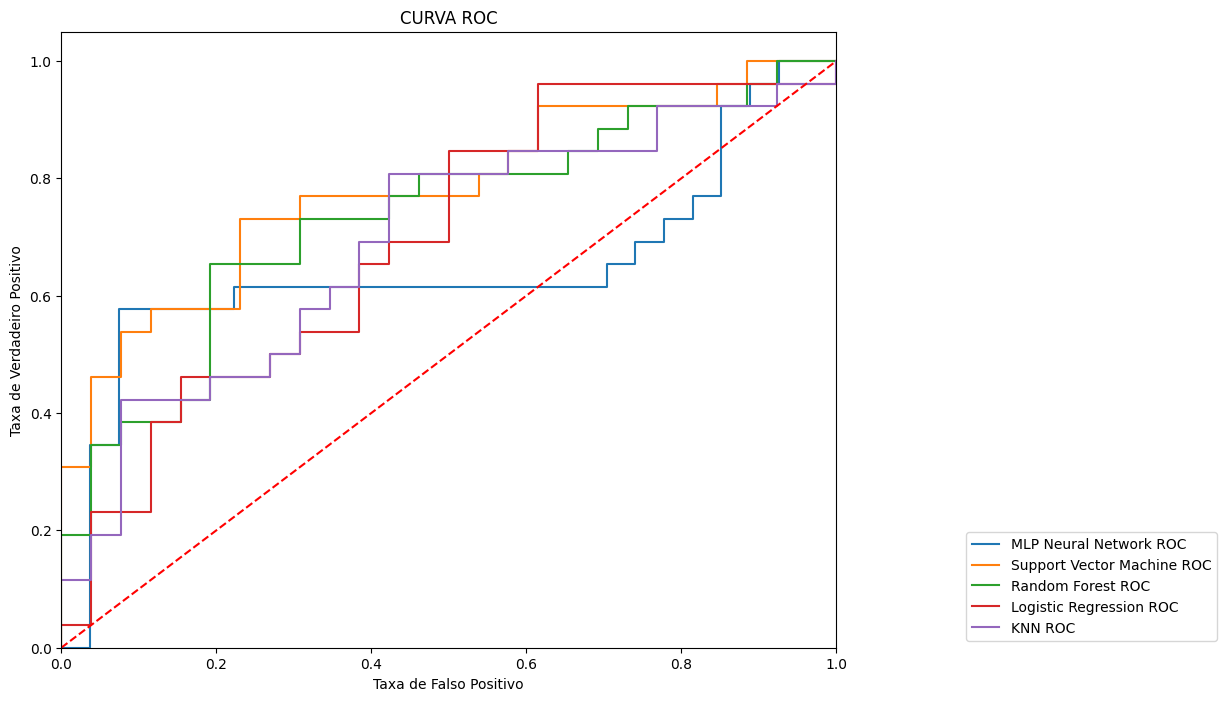

In [30]:
last_run_basic = analise_modelos(lista_modelos, dfx, dfy)

## 3.3 - Treinando Ensembles

In [31]:
last_run_all = deepcopy(last_run_basic)

In [32]:
#models_list = ['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN']

for model_name in BASIC_MODEL_NAMES:
    print(f"\n\n\n **** TREINANDO ENSEMBLE PARA {model_name} ****\n")
    contracted_name = ''.join([name[0] for name in model_name.split()])
    results_ensemble = train_ensemble(select_best_models_of_type_fn(model_name), last_run_all, dfx, dfy, name_prefix=contracted_name)

    # merge results with results_with_ensemble
    last_run_all.update(results_ensemble)




 **** TREINANDO ENSEMBLE PARA MLP Neural Network ****

..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


...


 **** TREINANDO ENSEMBLE PARA Support Vector Machine ****

..........


 **** TREINANDO ENSEMBLE PARA Random Forest ****

..........


 **** TREINANDO ENSEMBLE PARA Logistic Regression ****

.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


.


 **** TREINANDO ENSEMBLE PARA KNN ****

..........

In [33]:
results_ensemble = train_ensemble(select_best_models_per_fold, last_run_basic, dfx, dfy, name_prefix="BPF")  # BPF - best per fold

# check if keys have no intersection
assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0

# merge results with results_with_ensemble
last_run_all.update(results_ensemble)

..........

In [34]:
last_run_all.keys()

dict_keys(['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN', 'MNN-hard-vote', 'MNN-soft-vote', 'SVM-hard-vote', 'SVM-soft-vote', 'RF-hard-vote', 'RF-soft-vote', 'LR-hard-vote', 'LR-soft-vote', 'K-hard-vote', 'K-soft-vote', 'BPF-hard-vote', 'BPF-soft-vote'])

In [35]:
#save_results(f'./resultados/resultados50p_{FILE_NAME_SUFFIX}.npy', last_run_all, description)

# 4. Análise dos Resultados

In [94]:
#BASE_FILE_NAME = "resultados50p_2024-05-04_lula_artigo2"
BASE_FILE_NAME = "resultados50p_2024-05-04_bolsonaro_artigo2"
loaded_results = load_results(f"./resultados/{BASE_FILE_NAME}.npy")

Carregado arquivo de resultados com descrição:
Treinamento com modelos com os novos dados balanceados (50p), 
com o dataset bolsonaro, com todos os modelos e com todos os ENSEMBLE,
com uma versão mais nova do scikit-learn, 
com a correção de escala para a MLP,
com 2 atributos para o candidato


Escolher abaixo se deseja analisar os resultados carregados de arquivo ou os dados da última execução.

In [95]:
#results = last_run_all
#results = last_run_basic
results = loaded_results

In [96]:
results.keys()

dict_keys(['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN', 'MNN-hard-vote', 'MNN-soft-vote', 'SVM-hard-vote', 'SVM-soft-vote', 'RF-hard-vote', 'RF-soft-vote', 'LR-hard-vote', 'LR-soft-vote', 'K-hard-vote', 'K-soft-vote', 'BPF-hard-vote', 'BPF-soft-vote'])

## 4.1 - Métricas Principais

In [97]:
from ipywidgets import interact

In [98]:
#METRICS = ['Acurácia_mean', 'Precisão_mean', 'Revocação_mean', 'F1_score_mean', 'aucROC_mean']
METRICS = ['F1_score_mean', 'F1_score_std', 'Precisão_mean', 'Precisão_std', 'Revocação_mean', 'Revocação_std', 'Acurácia_mean', 'Acurácia_std']

In [99]:
df_result = pd.DataFrame(results).T
df_result = df_result[METRICS]

In [100]:
df_result.loc[df_result.index.isin(BASIC_MODEL_NAMES), :].sort_values('F1_score_mean', ascending=False)

,F1_score_mean,F1_score_std,Precisão_mean,Precisão_std,Revocação_mean,Revocação_std,Acurácia_mean,Acurácia_std
Support Vector Machine,0.693141,0.060666,0.688615,0.038508,0.707692,0.110405,0.693469,0.043914
Logistic Regression,0.684699,0.039504,0.6869,0.03853,0.692308,0.087706,0.685922,0.024636
KNN,0.670408,0.036165,0.69562,0.069788,0.653846,0.04865,0.678157,0.053539
MLP Neural Network,0.660465,0.046335,0.655407,0.04328,0.669231,0.071336,0.659071,0.040378
Random Forest,0.647864,0.07305,0.672765,0.078943,0.661538,0.163902,0.655225,0.052585


In [101]:
def order_models_by(order_by):
    display(df_result.sort_values(by=order_by, ascending=False))
    return

interact(order_models_by, order_by=METRICS);

interactive(children=(Dropdown(description='order_by', options=('F1_score_mean', 'F1_score_std', 'Precisão_mea…

**Classificador Aleatório**

In [102]:
def random_classifier_results(y_true, chance_for_class1=0.5, trials=100):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    for i in range(trials):
        y_pred = np.random.choice([0, 1], size=len(y_true), p=[1.0-chance_for_class1, chance_for_class1])
        accuracies.append(metrics.accuracy_score(y_true, y_pred))
        precisions.append(metrics.precision_score(y_true, y_pred))
        recalls.append(metrics.recall_score(y_true, y_pred))
        f1s.append(metrics.f1_score(y_true, y_pred))
    print(f"RANDOM CLASSIFIER ({100*chance_for_class1:.0f}% chance for class 1)")
    print(f"- Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.5f}") 
    print(f"- Precision: {np.mean(precisions):.4f} +/- {np.std(precisions):.5f}")
    print(f"- Recall: {np.mean(recalls):.4f} +/- {np.std(recalls):.5f}")
    print(f"- F1-Score: {np.mean(f1s):.4f} +/- {np.std(f1s):.5f}")

In [103]:
random_classifier_results(dfy, 0.50)

RANDOM CLASSIFIER (50% chance for class 1)
- Accuracy: 0.4971 +/- 0.03107
- Precision: 0.4951 +/- 0.03181
- Recall: 0.4932 +/- 0.04353
- F1-Score: 0.4937 +/- 0.03498


## 4.2 - Melhores Hiper-Parâmetros

**Valores de parâmetros mais frequentes entre os melhores, por modelo**

In [104]:
from collections import Counter

def aggregate_best_params(model_name):
    best_params_list = results[model_name]['melhores_parametros']
    
    # for each name of parameter, counts the number of times each of its value appeared among the best
    params_count = dict()

    for param_name in best_params_list[0].keys():
        # fora each value of the parameter, counts the occurences
        params_count[param_name] = Counter()
        
        for params in best_params_list:
            if param_name == 'preproc':
                param_value = params[param_name]._simplified_name
            else:
                param_value = params[param_name]
            params_count[param_name][param_value] += 1
    
    display(params_count)

#aggregate_best_params('Logistic Regression')
interact(aggregate_best_params, model_name=BASIC_MODEL_NAMES)

interactive(children=(Dropdown(description='model_name', options=('MLP Neural Network', 'Support Vector Machin…

<function __main__.aggregate_best_params(model_name)>

**Melhores hiperparâmetros por fold (entre todos os modelos)**

In [105]:
def list_best_model_per_fold():
    for fold in range(5):   
        best_f1 = 0.0
        best_model_params = None
        best_model_name = None
        for model_name in results.keys():
            # ignora modelos ensemble
            if 'melhores_parametros' not in results[model_name]:
                continue
            
            if results[model_name]['F1_score_list'][fold] > best_f1:
                best_f1 = results[model_name]['F1_score_list'][fold]
                best_model_params = results[model_name]['melhores_parametros'][fold]
                best_model_name = model_name
        
        print(f"FOLD {fold} - best model is a '{best_model_name}' with hiper parameters:")
        for key in best_model_params:
            if key == 'preproc':
                print(f" - {key}: {best_model_params[key]._simplified_name}")
            else:
                print(f" - {key}: {best_model_params[key]}")
        print(f" - F1 score: {results[best_model_name]['F1_score_list'][fold]:.4f}")


list_best_model_per_fold()

FOLD 0 - best model is a 'Support Vector Machine' with hiper parameters:
 - predictor__C: 1.0
 - predictor__class_weight: balanced
 - predictor__gamma: scale
 - predictor__kernel: rbf
 - preproc: TargetEncoder(target_type='binary')
 - scaler: MinMaxScaler()
 - F1 score: 0.6667
FOLD 1 - best model is a 'Random Forest' with hiper parameters:
 - predictor__class_weight: None
 - predictor__max_depth: 3
 - predictor__min_samples_split: 4
 - predictor__n_estimators: 30
 - preproc: TargetEncoder(target_type='binary')
 - F1 score: 0.7667
FOLD 2 - best model is a 'Support Vector Machine' with hiper parameters:
 - predictor__C: 0.1
 - predictor__class_weight: balanced
 - predictor__gamma: auto
 - predictor__kernel: rbf
 - preproc: OneHotEncoder(drop='if_binary')
 - scaler: StandardScaler()
 - F1 score: 0.7636
FOLD 3 - best model is a 'Logistic Regression' with hiper parameters:
 - predictor__C: 2.0
 - predictor__class_weight: balanced
 - predictor__penalty: l1
 - preproc: TargetEncoderX(target_t

**Melhores hiperparâmetros por modelo (todos os folds)**

In [106]:
def list_all_best_params(model_name):
    best_params_list = results[model_name]['melhores_parametros']
    for i, paramset in enumerate(best_params_list):
        print("BEST PARAM SET IN FOLD", i, ":")
        for key in paramset.keys():
            if key == 'preproc':
                print(f" - {key}: {paramset[key]._simplified_name}")
            else:
                print(f" - {key}: {paramset[key]}")
        print(f" - F1 score: {results[model_name]['F1_score_list'][i]:.4f}")


#list_all_best_params('Logistic Regression')
#list_all_best_params('Random Forest')
#list_all_best_params('Support Vector Machine')

interact(list_all_best_params, model_name=BASIC_MODEL_NAMES)

interactive(children=(Dropdown(description='model_name', options=('MLP Neural Network', 'Support Vector Machin…

<function __main__.list_all_best_params(model_name)>

In [107]:
#results["Support Vector Machine"]["melhores_modelos"]


## 4.3 - Importância dos Atributos


- Baseado nos valores de `feature_importances_` calculados em alguns modelos

In [108]:
#@title Definições auxiliares (não precisa abrir)
from sklearn.tree import plot_tree
import numpy as np
import matplotlib.pyplot as plt

def plot_importance(importances, title=None, max_features=None, feature_names=None, sort=True, ax=None):
    """
    Plot feature importances for a scikit-learn random forest or gradient boosting model.

    Parameters
    ----------
    model : object
        A scikit-learn random forest or gradient boosting model.
    title: str or None, optional (default=None)
        The title of the plot.
    max_features : int or None, optional (default=None)
        The maximum number of features to plot. If None, plot all features.
    feature_names : list or None, optional (default=None)
        A list of feature names to use in the plot. If None, use the feature indices.
    sort : bool, optional (default=True)
        Whether to sort the feature importances in descending order.
    ax : matplotlib.axes.Axes or None, optional (default=None)
        The matplotlib axes to plot the feature importances on. If None, create a new figure and axes.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes containing the plot.

    """
    # Extract feature importances
    #importances = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = [str(i) for i in range(len(importances))]

    # Sort feature importances
    if sort:
        indices = np.argsort(importances)[::-1]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    # Truncate feature importances
    if max_features is not None:
        importances = importances[:max_features]
        feature_names = feature_names[:max_features]

    # Create plot
    if ax is None:
        fig, ax = plt.subplots()
   
    if title:
        ax.set_title(title, fontsize=12)

    ax.barh(np.arange(len(importances)), importances, align='center')
    ax.set_yticks(np.arange(len(importances)))
    ax.set_yticklabels(feature_names)
    #ax.set_xlabel('Gini importance', fontsize=10)
    ax.invert_yaxis()

    return ax

In [109]:
if 'Decision Tree' in results:
    # best model of the 1st fold of the outer cross-validation
    dec_tree_pipeline = results['Decision Tree']['melhores_modelos'][0]

    # fit the pipeline to the WHOLE dataset
    dec_tree_pipeline.fit(dfx, dfy)

    display(dec_tree_pipeline)
    
    # the decision tree model inside the pipeline
    dec_tree = dec_tree_pipeline.named_steps['predictor']
    feature_names = dec_tree_pipeline.named_steps['preproc'].get_feature_names_out()

    fig = plt.figure(figsize=(22,15))
    plot_tree(dec_tree, feature_names=list(feature_names), filled=True);

In [110]:
to_translate = {'cat__': '', 'remainder__': '', 
                    'DiasDecorridos': 'Elapsed Days', 
                    'Dispositivo Retórico': 'Rhetorical Device',
                    'Retórica Aristotélica': 'Aristotelian Rhetoric',
                    'Tipo de conteúdo': 'Content Type',
                    'Texto': 'Text',
                    'Tonalidade': 'Tone',
                    'Duracao': 'Duration',
                    'Abordagem': 'Approach'}

def translate_feature_names(feature_names):
    translated_names = []
    for name in feature_names:
        for k in to_translate.keys():
            name = name.replace(k, to_translate[k])
        translated_names.append(name)
    return translated_names

Mostras as importâncias para CADA um dos 5 modelos (dos 5 folds):

O modelo MLP Neural Network não registra as importâncias das features
O modelo Support Vector Machine não registra as importâncias das features
O modelo Logistic Regression não registra as importâncias das features
O modelo KNN não registra as importâncias das features


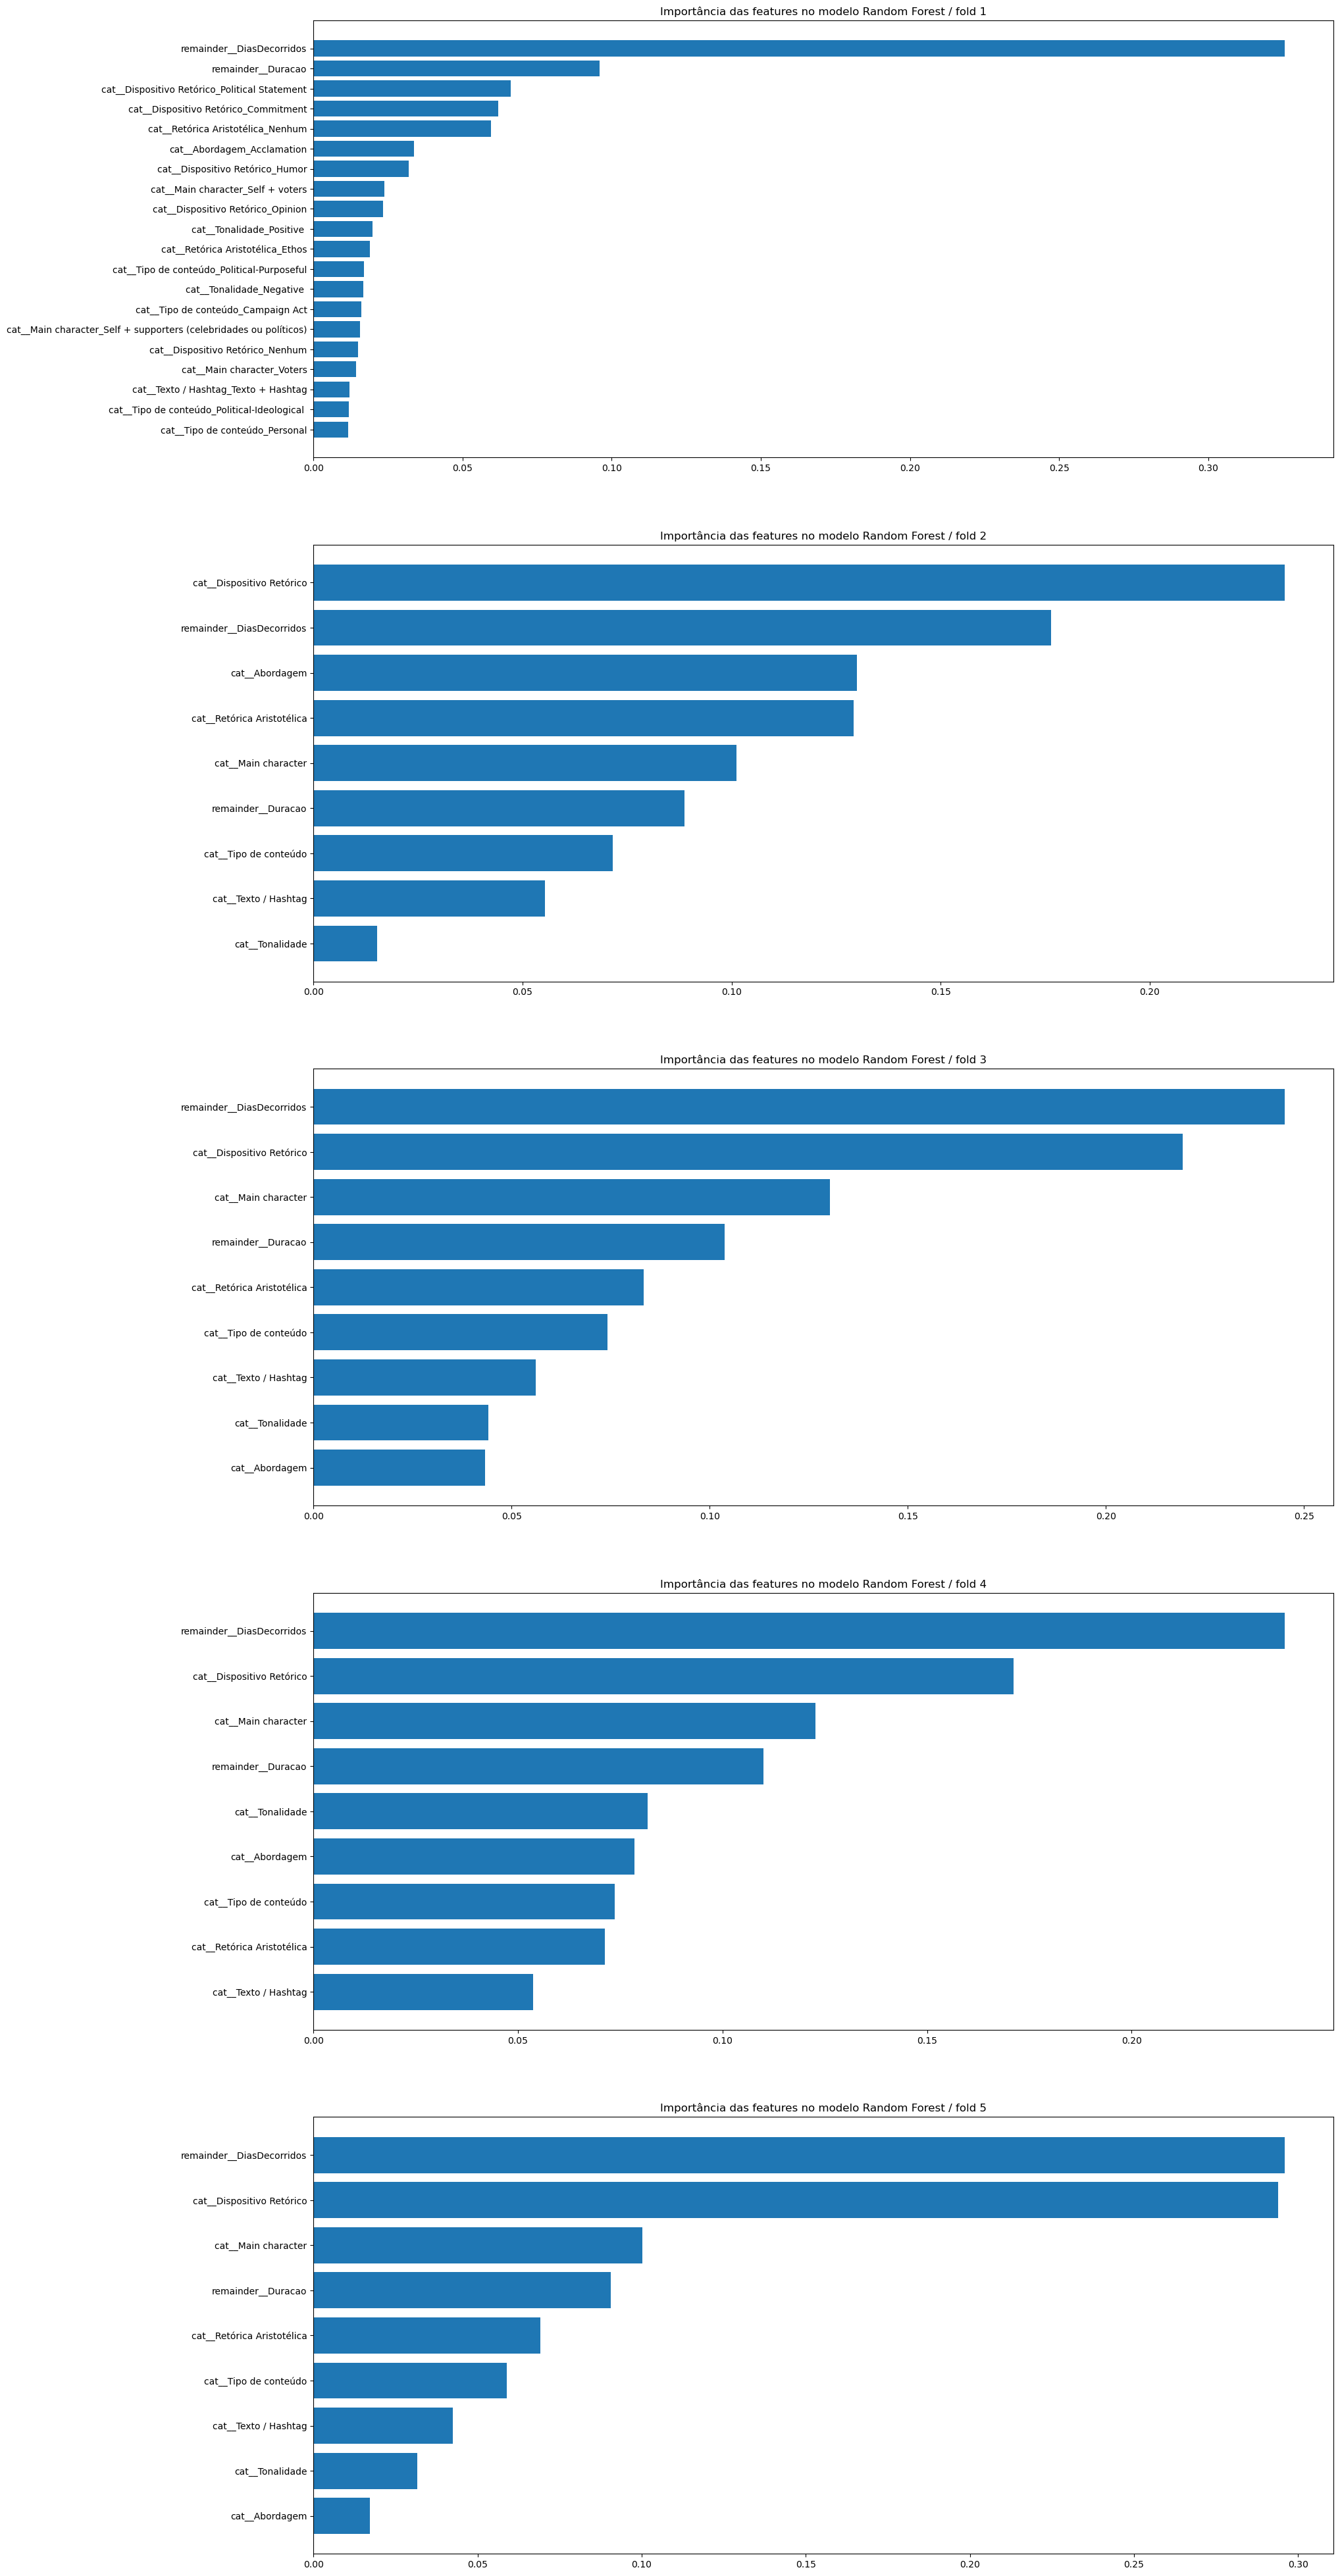

In [111]:
for model_name in results.keys():
    if 'vote' in model_name:
        continue

    model_pipeline = results[model_name]['melhores_modelos'][0]  # the best model found in the first fold
    model_predictor = model_pipeline.named_steps['predictor']

    # testa se o modelo guarda as importâncias das features
    if not hasattr(model_predictor, 'feature_importances_'):
        print(f"O modelo {model_name} não registra as importâncias das features")
        continue

    fig, axs = plt.subplots(5, 1, figsize=(20, 50))
    
    # Configurando a validação cruzada externa (igual à da função de treinamento)
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold = 0
    for train_ix, test_ix in cv_outer.split(dfx, dfy):
    #for fold in range(5):
        X_train = dfx.iloc[train_ix]
        y_train = dfy.iloc[train_ix]

        model_pipeline = results[model_name]['melhores_modelos'][fold]
        model_predictor = model_pipeline.named_steps['predictor']
        
        model_pipeline.fit(X_train, y_train)
        #model_pipeline.fit(dfx, dfy) # PENSAR: refazer o cv_outer ?

        features = model_pipeline.named_steps['preproc'].get_feature_names_out()
        importances = model_predictor.feature_importances_
        plot_importance(importances, 
                        title=f"Importância das features no modelo {model_name} / fold {fold+1}", 
                        feature_names=features, max_features=20, 
                        ax=axs[fold])
        fold += 1

Mostras as importâncias médias dos modelos agrupadas pelos que usam features semelhantes:

O modelo MLP Neural Network não registra as importâncias das features
O modelo Support Vector Machine não registra as importâncias das features
O modelo Logistic Regression não registra as importâncias das features
O modelo KNN não registra as importâncias das features


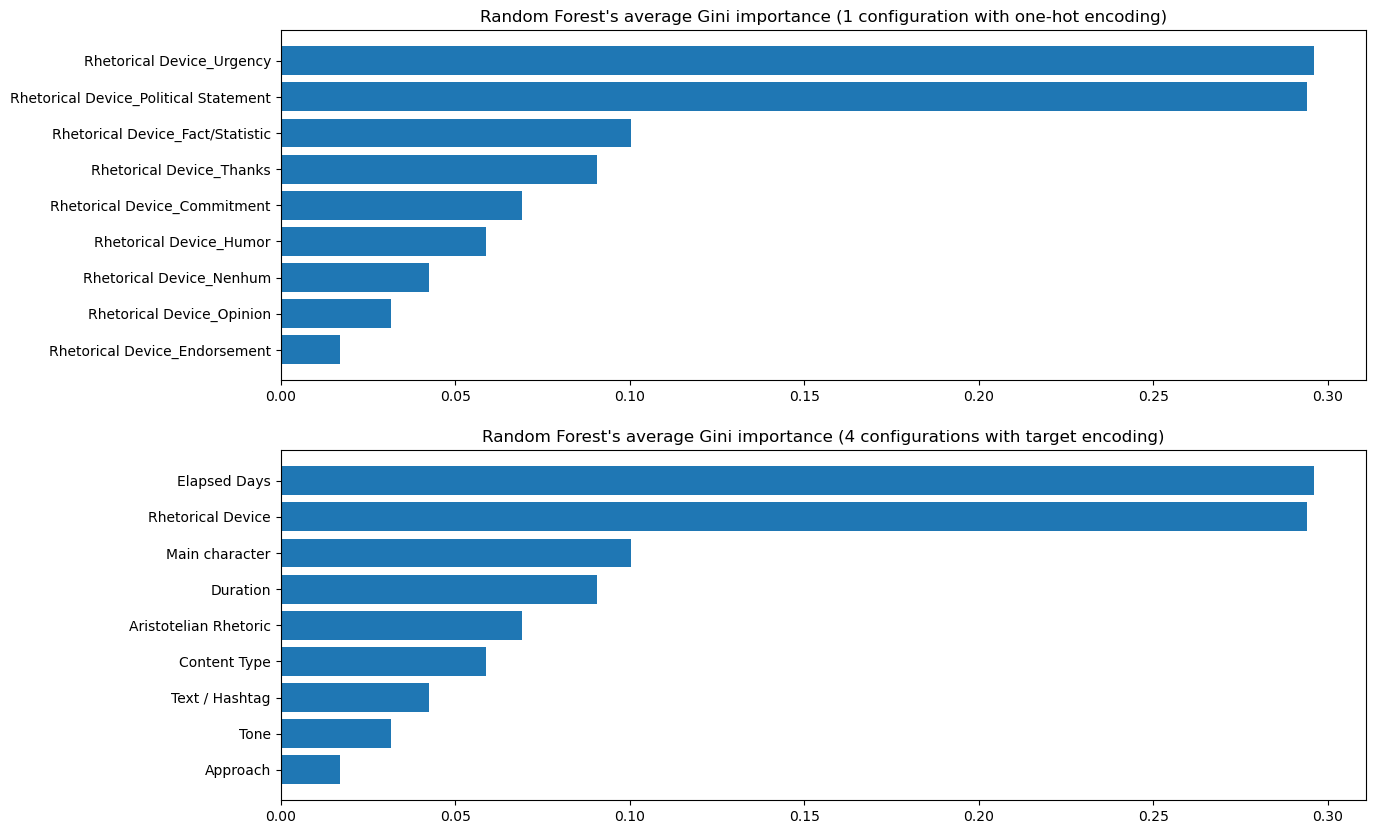

In [112]:
for model_name in results.keys():
    if 'vote' in model_name:
        continue

    model_pipeline = results[model_name]['melhores_modelos'][0]  # the best model found in the first fold
    model_predictor = model_pipeline.named_steps['predictor']

    # testa se o modelo guarda as importâncias das features
    if not hasattr(model_predictor, 'feature_importances_'):
        print(f"O modelo {model_name} não registra as importâncias das features")
        continue

    map_num_features_to_importances = dict()
    
    # groups the models that uses similarly modified features
    for fold in range(5):
        model_pipeline = results[model_name]['melhores_modelos'][fold]
        model_predictor = model_pipeline.named_steps['predictor']
        
        # não precisa, porque já foi treinado na célula anterior
        #model_pipeline.fit(...)

        features = model_pipeline.named_steps['preproc'].get_feature_names_out()

        num_features = len(features)
        #print("Fold", fold, ":", num_features)

        importances = model_predictor.feature_importances_
        assert len(importances) == num_features

        if num_features not in map_num_features_to_importances:
            map_num_features_to_importances[num_features] = []
        
        map_num_features_to_importances[num_features].append((features, importances))

    # plot the importances for each group of models
    num_groups = len(map_num_features_to_importances)
    fig, axs = plt.subplots(num_groups, 1, figsize=(14, 5*num_groups))
    
    for subplot, num_features in enumerate(map_num_features_to_importances.keys()):
        list_of_importances = map_num_features_to_importances[num_features]
        num_models = len(list_of_importances)
        
        # just to assure that the feature names are the same
        # across the different model configurations
        for j in range(len(list_of_importances)-1):
            assert (list_of_importances[j][0] == list_of_importances[j+1][0]).all()

        features = list_of_importances[0][0]
        features = translate_feature_names(features)
        mean_importances = np.mean([imp for (_, imp) in list_of_importances], axis=1)
        
        if num_groups > 1:
            param_ax = axs[subplot]
        else:
            param_ax = axs
        
        cat_feature_encoding = 'one-hot encoding' if len(features)==42 else 'target encoding'
        letter_s_if_plural   = 's' if num_models > 1 else ''

        plot_importance(importances, 
                        title=f"Random Forest's average Gini importance ({num_models} configuration{letter_s_if_plural} with {cat_feature_encoding})", 
                        feature_names=features, 
                        max_features=20, 
                        ax=param_ax)


# FIM